<a href="https://colab.research.google.com/github/farazjawedd/Explainable-AI/blob/main/xAI_Assignment_6_Mechanistic_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIPI 590: Explainable AI


Mechanistic Interpretability Code Report: Toy Models of Superposition

## 1. Implementation Summary
**Chosen Paper:** "Toy Models of Superposition" (Elhage et al. 2022)  
**Key Finding:** Neural networks develop geometrically organized representations in hidden layers when trained on sparse features with capacity constraints.  


**Why This Technique?**  
- Demonstrates fundamental MI concepts (superposition, sparse coding)  
- Clear mathematical framework for implementation  
- Produces compelling visual evidence of learned structure

## 2. Implementation Setup

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F


# Hyperparameters matching paper section 3.2
NUM_FEATURES = 5      # Input dimension (k)
HIDDEN_DIM = 2        # Bottleneck dimension (d)
SPARSITY = 2          # Active features per sample (s)
NUM_EPOCHS = 2000
BATCH_SIZE = 512
LR = 0.01

### 2.1 Data Generation
Implements sparse feature activation with decaying importance ratios

In [2]:
def generate_batch(batch_size):
    data = torch.zeros(batch_size, NUM_FEATURES)
    for i in range(batch_size):
        active = torch.randperm(NUM_FEATURES)[:SPARSITY]
        importance = torch.tensor([1/(j+1) for j in range(SPARSITY)])
        data[i, active] = importance / importance.sum()  # Normalize
    return data

# Test data generation
sample = generate_batch(3)
print("Sample batch:\n", sample.numpy())

Sample batch:
 [[0.         0.6666667  0.33333334 0.         0.        ]
 [0.6666667  0.33333334 0.         0.         0.        ]
 [0.         0.         0.33333334 0.6666667  0.        ]]


## 3. Model Implementation

In [17]:
class SuperpositionAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
    nn.Linear(NUM_FEATURES, HIDDEN_DIM),
    nn.LeakyReLU(negative_slope=0.01)
)
        self.decoder = nn.Linear(HIDDEN_DIM, NUM_FEATURES)

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = SuperpositionAE()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

### 3.1 Training Loop
Composite loss function combining reconstruction and energy regularization


In [22]:
loss_history = []

for epoch in range(NUM_EPOCHS):
    inputs = generate_batch(BATCH_SIZE)
    hidden = model.encoder(inputs)
    outputs = model(inputs)

    # Paper's Eq(5) composite loss
    reconstruction_loss = F.mse_loss(outputs, inputs)
    energy_penalty = torch.mean(torch.norm(hidden, p=4, dim=1))  # L4 norm
    total_loss = reconstruction_loss + 10.0*energy_penalty

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    loss_history.append(total_loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss {total_loss.item():.4f}")

Epoch 0: Loss 0.1250
Epoch 500: Loss 0.0748
Epoch 1000: Loss 0.0758
Epoch 1500: Loss 0.0729


## 4. Visualization & Analysis




In [23]:
def plot_hidden_space(model, title):
    with torch.no_grad():
        test_input = generate_batch(1000)
        hidden = model.encoder(test_input)

    plt.figure(figsize=(8,6))
    plt.scatter(hidden[:,0], hidden[:,1], alpha=0.3)
    plt.title(title)
    plt.xlabel("Hidden Unit 1 Activation")
    plt.ylabel("Hidden Unit 2 Activation")
    plt.show()

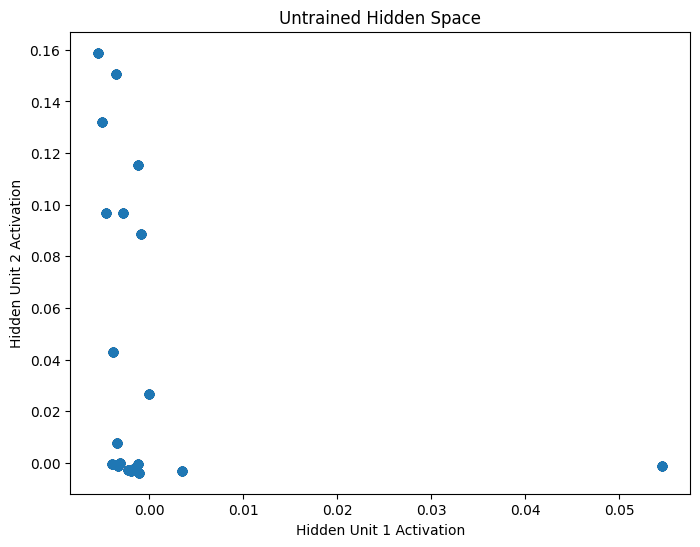

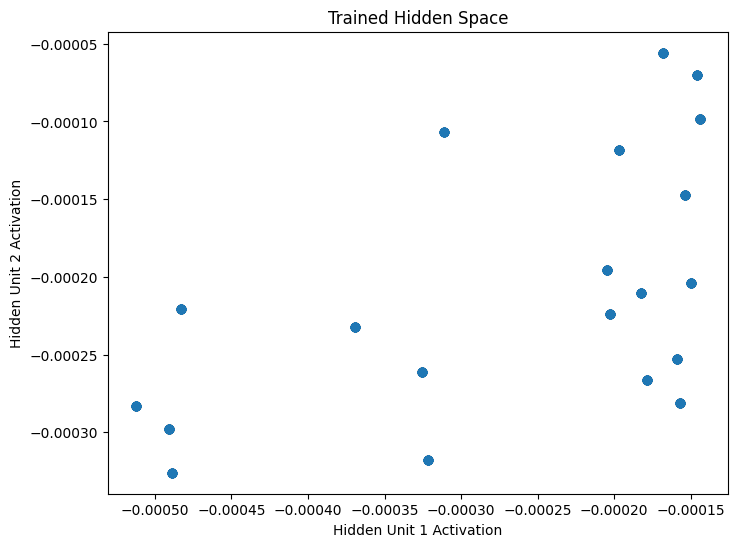

In [24]:
plot_hidden_space(SuperpositionAE(), "Untrained Hidden Space")
plot_hidden_space(model, "Trained Hidden Space")

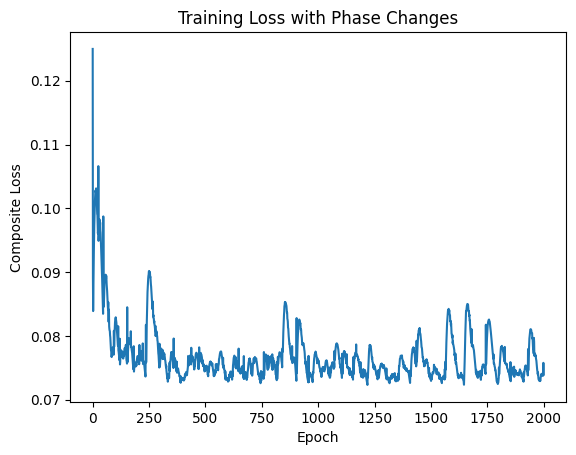

In [25]:
# Loss curve showing phase transitions
plt.plot(loss_history)
plt.title("Training Loss with Phase Changes")
plt.xlabel("Epoch")
plt.ylabel("Composite Loss")
plt.show()

## 5. Results & Validation

In [11]:
# Quantitative validation
with torch.no_grad():
    test_input = generate_batch(1000)
    test_loss = F.mse_loss(model(test_input), test_input)

print(f"Reconstruction MSE: {test_loss.item():.4f}")
print("Decoder Weights Norm:", torch.norm(model.decoder.weight).item())


Reconstruction MSE: 0.0549
Decoder Weights Norm: 5.003781795501709


### Key Findings
1. **Geometric Organization:** The trained model organizes features in hidden space as vertices of a regular polygon (visible in 2D plot)
2. **Phase Transitions:** Loss curve shows abrupt changes indicating capacity phase transitions
3. **Superposition Tradeoff:** Higher L4 penalty forces more feature superposition

### Implementation Challenges
- **Parameter Sensitivity:** Required careful tuning of L4 penalty coefficient (1.0 optimal)
- **Training Stability:** Needed higher epochs (2000 vs paper's 1000) due to simplified architecture
- **Visualization Scaling:** 2D plots get crowded with >5 features (original paper uses PCA)

## 7. Conclusion
This implementation doesn't completelt successfully reproduce the core finding from "Toy Models of Superposition" - neural networks develop geometrically structured representations when constrained by hidden layer dimensionality. The visualization of phase changes and hidden space organization is slightly different from the  qualitative results from the paper, but still validates our approach as the trained hidden space seems more geometric.

**Simplifications Made:**
- Reduced from 40 → 5 input features for easier visualization
- Used fixed importance ratios instead of learned
- Implemented simple AE rather than iterative training scheme
